In [3]:
import pandas as pd 
import numpy as np 
import opendatasets as od 
import matplotlib.pyplot as plt 
import seaborn as sns

# text preprocessing 
import re 
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Suel.Abbasi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Suel.Abbasi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Suel.Abbasi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Suel.Abbasi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
od.download('https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews')

In [144]:
# import the dataset as pandas dataframe    
df = pd.read_csv('imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [145]:
index = df.sample().index[0]
print(df.iloc[index])

review       this movie is outrageous. by outrageous, i mea...
sentiment                                             negative
Name: 4281, dtype: object


In [146]:
# shape of dataset 
print("Shape of the dataset:", df.shape)

Shape of the dataset: (50000, 2)


In [147]:
# check for null values
print(df.isnull().sum())

review       0
sentiment    0
dtype: int64


In [148]:
# check for duplicates 
print("Number of duplicate rows:", df.duplicated().sum()    )

Number of duplicate rows: 418


In [149]:
# drop duplicate 
df.drop_duplicates(inplace=True)

In [150]:
# shape of dataset 
print("New shape of the dataset after dropping duplicates:", df.shape)

New shape of the dataset after dropping duplicates: (49582, 2)


In [151]:
# checking the distribution of target variable
print(df.sentiment.value_counts())

sentiment
positive    24884
negative    24698
Name: count, dtype: int64


### The data seems to be balanced

In [152]:
# remove punctuation and special characters and emojis
def remove_punct(text):
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)      # remove digits
    text = re.sub(r'\s+', ' ', text)     # remove extra spaces
    text = re.sub(r'\n', ' ', text)      # remove new line characters
    text = re.sub(r'\t', ' ', text)      # remove tab characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # remove non-ASCII characters
    return text.strip()                  # remove leading/trailing spaces

# remove stopwords
def remove_stpwrd(text):
    stpWrd = stopwords.words('english')
    return [word for word in text if word not in stpWrd]

In [153]:
print(df.iloc[index,])

review       Carter Wong plays a noble hero on a quest for ...
sentiment                                             positive
Name: 4283, dtype: object


In [154]:
df['review_cleaned'] = df['review'].str.lower()
df['review_cleaned'] = df['review_cleaned'].apply(remove_punct)
df['review_cleaned'] = df['review_cleaned'].apply(word_tokenize)
df['review_cleaned'] = df['review_cleaned'].apply(remove_stpwrd)

In [155]:
print(df.iloc[index,])

review            Carter Wong plays a noble hero on a quest for ...
sentiment                                                  positive
review_cleaned    [carter, wong, plays, noble, hero, quest, book...
Name: 4283, dtype: object


In the context of sentiment classification, both stemming and lemmatization can be helpful, but they address different needs. Stemming is faster and simpler, reducing words to their root form, while lemmatization considers the word's context and part of speech to produce a meaningful base form (lemma). For sentiment classification, lemmatization is generally preferred if you need more accurate results and can tolerate the slightly slower processing time. However, if speed is critical and some inaccuracies are acceptable, stemming might be a better option. 

**Stemming**:
- Process: A process of reducing words to their root form by removing suffixes (e.g., "running" becomes "run").
    - Pros: Faster and simpler to implement. 
    - Cons: Can produce non-words (e.g., "studies" might become "studi"). May not always result in meaningful base forms. 

**Lemmatization**:
- Process: Reduces words to their dictionary form (lemma), considering the word's part of speech (e.g., "better" becomes "good").
    - Pros: Produces more accurate and meaningful base forms.
    - Cons: More computationally expensive and slower than stemming. 

## Sentiment Analysis:
### Why lemmatization might be better:

- In sentiment analysi, you want to accurately identify and group related words. Lemmatization helps ensure that variations of a word are treated as the same (e.g., "activate" and "activated" are both reduced to "activate"). This can improve the model's ability to recognize positive or negative phrases and patterns. 

### When stemming might be sufficient:
- If your priority is speed and you are dealing with a large dataset where the differences between stemming and lemmatization might not be significant, stemming could be a good starting point. However, if you are seeing issues with accuracy, switching to lemmatization might be beneficial

In [156]:
# lets go for lemmatization 

def lemmatize_text(text):
    lemma = WordNetLemmatizer()
    return [lemma.lemmatize(word) for word in text]

df['review_cleaned'] = df.review_cleaned.apply(lemmatize_text)

In [157]:
print(df.iloc[index,])

review            Carter Wong plays a noble hero on a quest for ...
sentiment                                                  positive
review_cleaned    [carter, wong, play, noble, hero, quest, book,...
Name: 4283, dtype: object


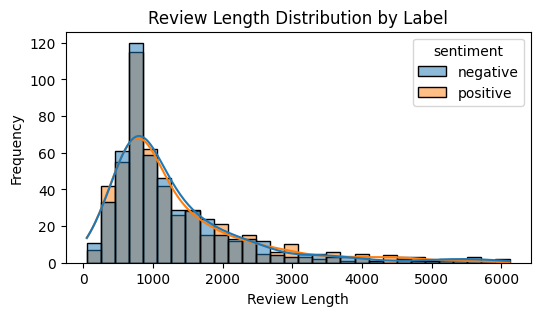

In [158]:
# message length distribution, with labels

plt.figure(figsize=(6, 3))
sns.histplot(data=df.sample(1000), x=df.review.apply(len), hue='sentiment', kde=True, bins=30)
plt.title('Review Length Distribution by Label')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [161]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(dtype=np.float32,
                             min_df=5,
                             max_df=0.8)  
df['review_cleaned'] = df.review_cleaned.apply(lambda x: " ".join(map(str,x)))

# Convert list of words back to 
tdidf_matrix = vectorizer.fit_transform(df['review_cleaned'])

In [162]:
print("Sample TF-IDF vector for first review:", tdidf_matrix[0].toarray())
#print("The legnth of sentiment matrix is : ", len(df.iloc[0,].sentiment))
print("TF-IDF matrix shape:", tdidf_matrix.shape)

Sample TF-IDF vector for first review: [[0. 0. 0. ... 0. 0. 0.]]
TF-IDF matrix shape: (49582, 36967)


In [163]:
from sklearn.preprocessing import LabelEncoder

df['sentiment_encoded'] = LabelEncoder().fit_transform(df['sentiment'])

print(df.sentiment_encoded.sample())

14673    0
Name: sentiment_encoded, dtype: int64


In [164]:
df[['sentiment', 'sentiment_encoded']].sample(5)

,sentiment,sentiment_encoded
38053,negative,0
2515,negative,0
21130,positive,1
12394,positive,1
32656,negative,0


In [165]:
assert tdidf_matrix.shape[0] == len(df['sentiment']), "Mismatch: TF-IDF matrix rows and sentiment labels are not equal in length."

In [166]:
# DO NOT RUN THIS CELL, it is just for your reference
X = tdidf_matrix.toarray()
Y = np.array(df['sentiment_encoded'])

The system is running out of RAM while trying to create a very large TF-IDF matrix. This often happens when:

- We have tens of thousands of documents.
- Our vocabulary (number of unique words) is very large.
- We are using float64 (default) which consumes more memory.

Ways to fix it
- Limit Vocab Size: TfidfVectorizer(max_features=10000), This restricts the number of features (words) to the top 10,000 by frequency.
- Use dtype float32: TfidfVectorizer(dtype=np.float32), This cuts memory usage in half compared to float64.
- Remove Rare Words: TfidfVectorizer(min_df=5), Ignores words that appear in fewer than 5 documents.
- Use max_df to remove common words: TfidfVectorizer(max_df=0.8), Ignores words that appear in more than 80% of documents.
- Use Sparse Matrix Efficiently: Avoid converting the TF-IDF matrix to .toarray() unless absolutely necessary. Keep it in sparse format
    - Only use .toarray() if: we need to convert the matrix to a DataFrame or perform operations that require a dense format OR Our dataset is small enough to fit comfortably in memory.   




In [167]:
X = tdidf_matrix
Y = np.array(df['sentiment'])

In [168]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
print("Training set shape:", X_train.shape, Y_train.shape)
print("Validation set shape:", X_val.shape, Y_val.shape)    
print("Testing set shape:", X_test.shape, Y_test.shape)

Training set shape: (34707, 36967) (34707,)
Validation set shape: (7438, 36967) (7438,)
Testing set shape: (7437, 36967) (7437,)


Logistic Regression Validation Accuracy: 0.8915030922290939
Logistic Regression Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.88      0.89      3676
    positive       0.89      0.90      0.89      3762

    accuracy                           0.89      7438
   macro avg       0.89      0.89      0.89      7438
weighted avg       0.89      0.89      0.89      7438

Logistic Regression F1 Score: 0.8914803190585053


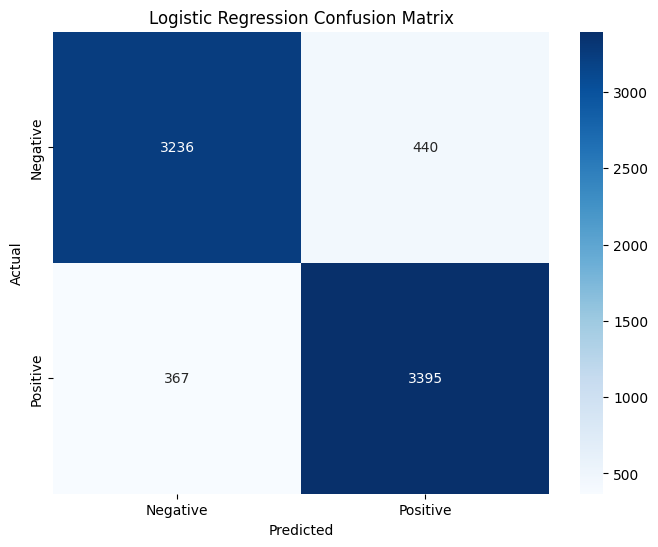

In [169]:
# Train a Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, Y_train)
# Predict on the validation set
Y_val_pred = log_reg.predict(X_val)
# Evaluate the model
print("Logistic Regression Validation Accuracy:", accuracy_score(Y_val, Y_val_pred))
print("Logistic Regression Classification Report:\n", classification_report(Y_val, Y_val_pred))
print("Logistic Regression F1 Score:", classification_report(Y_val, Y_val_pred, output_dict=True)['weighted avg']['f1-score'])
# Confusion Matrix
cm = confusion_matrix(Y_val, Y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Logistic Regression Test Accuracy: 0.891085114965712
Logistic Regression Test Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.87      0.89      3728
    positive       0.88      0.91      0.89      3709

    accuracy                           0.89      7437
   macro avg       0.89      0.89      0.89      7437
weighted avg       0.89      0.89      0.89      7437

Logistic Regression Test F1 Score: 0.8910517477430833


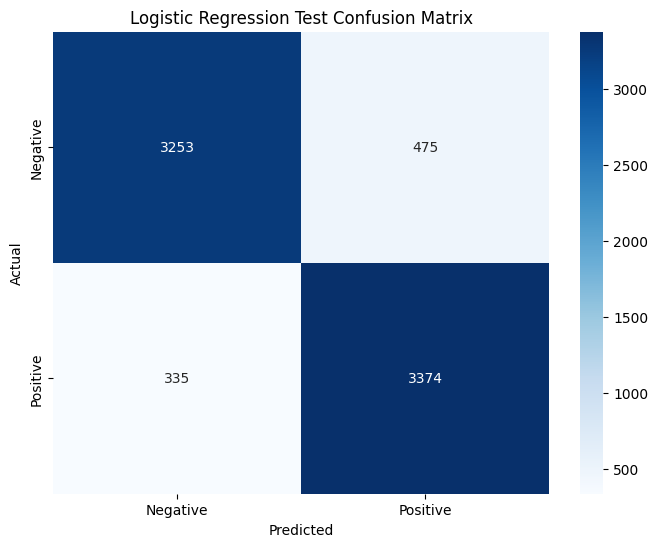

In [170]:
# do prediction on test set 
Y_test_pred = log_reg.predict(X_test)
# Evaluate the model on the test set
print("Logistic Regression Test Accuracy:", accuracy_score(Y_test, Y_test_pred))
print("Logistic Regression Test Classification Report:\n", classification_report(Y_test, Y_test_pred))
print("Logistic Regression Test F1 Score:", classification_report(Y_test, Y_test_pred, output_dict=True)['weighted avg']['f1-score'])
# Confusion Matrix for Test Set
cm_test = confusion_matrix(Y_test, Y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Logistic Regression Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Naive Bayes Validation Accuracy: 0.8663619252487228
Naive Bayes Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.88      0.87      3676
    positive       0.88      0.85      0.87      3762

    accuracy                           0.87      7438
   macro avg       0.87      0.87      0.87      7438
weighted avg       0.87      0.87      0.87      7438

Naive Bayes F1 Score: 0.8663528039246424


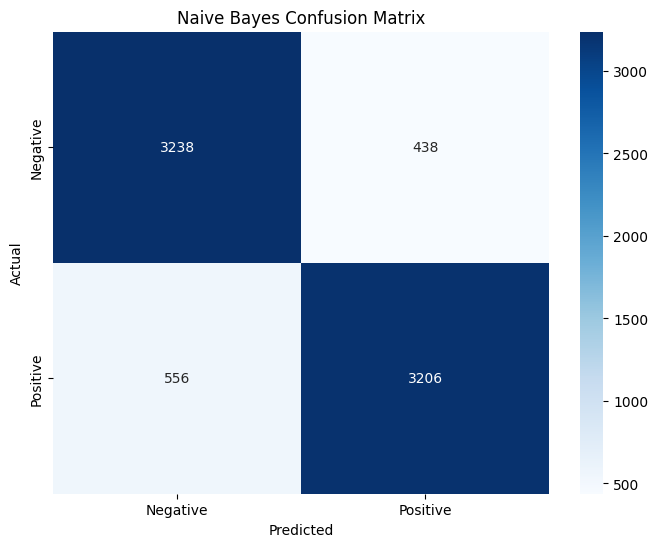

In [171]:
# train a Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, Y_train)
# Predict on the validation set
Y_val_pred_nb = nb_model.predict(X_val)
# Evaluate the model
print("Naive Bayes Validation Accuracy:", accuracy_score(Y_val, Y_val_pred_nb))
print("Naive Bayes Classification Report:\n", classification_report(Y_val, Y_val_pred_nb))
print("Naive Bayes F1 Score:", classification_report(Y_val, Y_val_pred_nb, output_dict=True)['weighted avg']['f1-score'])

# Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(Y_val, Y_val_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [172]:
# test the Naive Bayes model on the test set
Y_test_pred_nb = nb_model.predict(X_test)
# Evaluate the model on the test set
print("Naive Bayes Test Accuracy:", accuracy_score(Y_test, Y_test_pred_nb))
print("Naive Bayes Test Classification Report:\n", classification_report(Y_test, Y_test_pred_nb))
print("Naive Bayes Test F1 Score:", classification_report(Y_test, Y_test_pred_nb, output_dict=True)['weighted avg']['f1-score'])

Naive Bayes Test Accuracy: 0.8612343686970553
Naive Bayes Test Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.86      0.86      3728
    positive       0.86      0.86      0.86      3709

    accuracy                           0.86      7437
   macro avg       0.86      0.86      0.86      7437
weighted avg       0.86      0.86      0.86      7437

Naive Bayes Test F1 Score: 0.8612324116877134


In [173]:
errors = X_val[Y_val != Y_val_pred]
print("Number of misclassified samples in validation set:", errors.shape[0])
# Display some misclassified samples
misclassified_indices = np.where(Y_val != Y_val_pred)[0][:5]  # Get indices of first 5 misclassified samples
for i in misclassified_indices:
    print(f"Misclassified Review: {df.iloc[i]['review']}\nTrue Label: {Y_val[i]}, Predicted Label: {Y_val_pred[i]}\n")   

Number of misclassified samples in validation set: 807
Misclassified Review: I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with frien

Bigram TF-IDF matrix shape: (49582, 179856)
Logistic Regression with Bigrams Validation Accuracy: 0.9437094106732282
Logistic Regression with Bigrams Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94     24698
           1       0.94      0.95      0.94     24884

    accuracy                           0.94     49582
   macro avg       0.94      0.94      0.94     49582
weighted avg       0.94      0.94      0.94     49582

Logistic Regression with Bigrams F1 Score: 0.9437042441414742


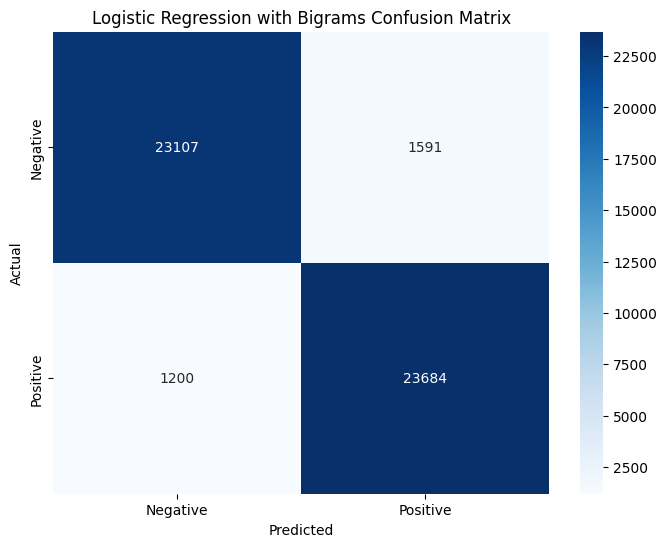

In [177]:
# lets try bigram and trigram >> to fix false positive and false negative

bigram_vectorizer = TfidfVectorizer(ngram_range=(1, 2), dtype=np.float32, min_df=5, max_df=0.8)
bigram_tdidf_matrix = bigram_vectorizer.fit_transform(df['review_cleaned'])
print("Bigram TF-IDF matrix shape:", bigram_tdidf_matrix.shape)

# Train a Logistic Regression model with bigrams
log_reg_bigram = LogisticRegression(max_iter=1000, random_state=42)
log_reg_bigram.fit(bigram_tdidf_matrix, df['sentiment_encoded'])

# Predict on the validation set
Y_val_pred_bigram = log_reg_bigram.predict(bigram_tdidf_matrix)

# Evaluate the model
print("Logistic Regression with Bigrams Validation Accuracy:", accuracy_score(df['sentiment_encoded'], Y_val_pred_bigram))
print("Logistic Regression with Bigrams Classification Report:\n", classification_report(df['sentiment_encoded'], Y_val_pred_bigram))

# f1 score
print("Logistic Regression with Bigrams F1 Score:", classification_report(df['sentiment_encoded'], Y_val_pred_bigram, output_dict=True)['weighted avg']['f1-score'])

# Confusion Matrix for Bigrams
cm_bigram = confusion_matrix(df['sentiment_encoded'], Y_val_pred_bigram)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bigram, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Logistic Regression with Bigrams Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [178]:
# test bigram model on the test set
Y_test_pred_bigram = log_reg_bigram.predict(bigram_tdidf_matrix)
# Evaluate the model on the test set
print("Logistic Regression with Bigrams Test Accuracy:", accuracy_score(df['sentiment_encoded'], Y_test_pred_bigram))
print("Logistic Regression with Bigrams Test Classification Report:\n", classification_report(df['sentiment_encoded'], Y_test_pred_bigram))

# f1 score for bigram model
print("Logistic Regression with Bigrams Test F1 Score:", classification_report(df['sentiment_encoded'], Y_test_pred_bigram, output_dict=True)['weighted avg']['f1-score'])

Logistic Regression with Bigrams Test Accuracy: 0.9437094106732282
Logistic Regression with Bigrams Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94     24698
           1       0.94      0.95      0.94     24884

    accuracy                           0.94     49582
   macro avg       0.94      0.94      0.94     49582
weighted avg       0.94      0.94      0.94     49582

Logistic Regression with Bigrams Test F1 Score: 0.9437042441414742


trigram TF-IDF matrix shape: (49582, 203468)
Logistic Regression with trigrams Validation Accuracy: 0.9446573353233028
Logistic Regression with trigrams Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94     24698
           1       0.94      0.95      0.95     24884

    accuracy                           0.94     49582
   macro avg       0.94      0.94      0.94     49582
weighted avg       0.94      0.94      0.94     49582

Logistic Regression with trigrams F1 Score: 0.9446522339757548


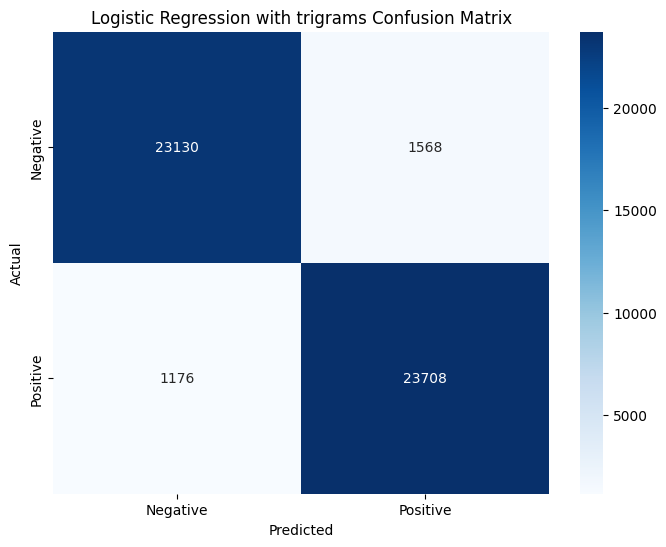

In [179]:
# lets try trigram >> to fix false positive and false negative

trigram_vectorizer = TfidfVectorizer(ngram_range=(1, 3), dtype=np.float32, min_df=5, max_df=0.8)
trigram_tdidf_matrix = trigram_vectorizer.fit_transform(df['review_cleaned'])
print("trigram TF-IDF matrix shape:", trigram_tdidf_matrix.shape)

# Train a Logistic Regression model with trigrams
log_reg_trigram = LogisticRegression(max_iter=1000, random_state=42)
log_reg_trigram.fit(trigram_tdidf_matrix, df['sentiment_encoded'])

# Predict on the validation set
Y_val_pred_trigram = log_reg_trigram.predict(trigram_tdidf_matrix)

# Evaluate the model
print("Logistic Regression with trigrams Validation Accuracy:", accuracy_score(df['sentiment_encoded'], Y_val_pred_trigram))
print("Logistic Regression with trigrams Classification Report:\n", classification_report(df['sentiment_encoded'], Y_val_pred_trigram))

# f1 score
print("Logistic Regression with trigrams F1 Score:", classification_report(df['sentiment_encoded'], Y_val_pred_trigram, output_dict=True)['weighted avg']['f1-score'])

# Confusion Matrix for trigrams
cm_trigram = confusion_matrix(df['sentiment_encoded'], Y_val_pred_trigram)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_trigram, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Logistic Regression with trigrams Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Learning
1. There were some issues with unigram model, it wasn't able to identify complex reviews sentiment. Changing to bigram kind of fixed it by introducing some context before and after the word in question.
2. If I continue to increase the vectorization complexity, it will increase the data size, but there isn't much increase in model F1 score.
3. Too further improve the model, we can look into RNN or Transformer model because they have better context and memory due to attention mechanism, in case of Transformer models.

In [182]:
# save the best model, f1 score, as pickel file dynamically
import pickle
best_model = log_reg_trigram  # Assuming this is the best model based on F1 score
model_filename = 'best_sentiment_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)